In [2]:
# Load the discharge_df to begin stationarity checks
# In Box-Jenkins, we first *identify* whether the series is stationary or needs differencing

import pandas as pd
import matplotlib.pyplot as plt

discharge_df = pd.read_csv('../data/discharge_df.csv')
discharge_df['start_datetime'] = pd.to_datetime(discharge_df['start_datetime'])
discharge_df['Capacity'] = discharge_df['Capacity'] = pd.to_numeric(discharge_df['Capacity'], errors='coerce')


In [6]:
# Pick a small sample of batteries to study in detail
# Identification phase in Box-Jenkins needs close visual and statistical inspection of a few good samples

sample_batteries = discharge_df['battery_id'].unique()[:4]


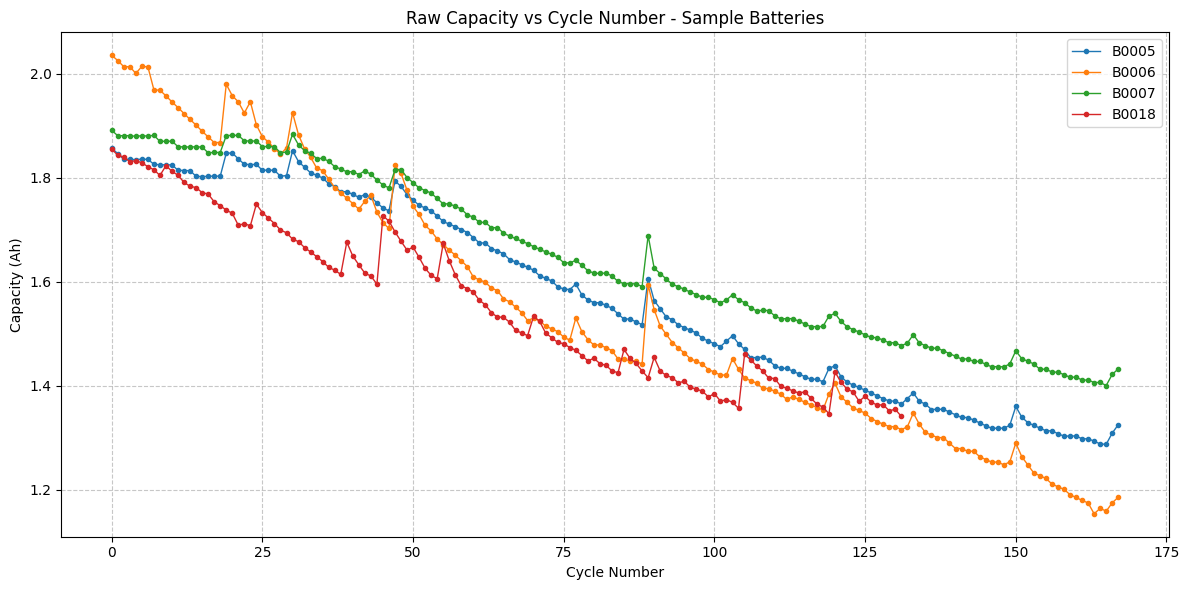

In [7]:
# Plot raw Capacity vs Cycle Number for a few batteries
# In the first step of Box-Jenkins, we visually confirm whether a trend exists (indicating non-stationarity)
plt.figure(figsize=(12,6))

for b in sample_batteries:
    temp = discharge_df[discharge_df['battery_id'] == b]
    plt.plot(temp['cycle_number'], temp['Capacity'], marker='o', linestyle='-', markersize=3, linewidth=1, label=b)

plt.xlabel('Cycle Number')
plt.ylabel('Capacity (Ah)')
plt.title('Raw Capacity vs Cycle Number - Sample Batteries')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Perform Augmented Dickey-Fuller (ADF) Test and print stationarity status
# In Box-Jenkins, this is part of identification step: verifying if differencing is needed

from statsmodels.tsa.stattools import adfuller

def adf_test(series, battery_id):
    result = adfuller(series.dropna())
    print(f"Battery: {battery_id}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is Stationary (p < 0.05)")
    else:
        print("Series is Non-Stationary (p > 0.05)")
    print("-"*50)

# Example usage: running on raw Capacity
for b in sample_batteries:
    temp = discharge_df[discharge_df['battery_id'] == b]
    print("\n")
    adf_test(temp['Capacity'], b)




Battery: B0005
ADF Statistic: -0.5256846711019765
p-value: 0.8869061026357296
Series is Non-Stationary (p > 0.05)
--------------------------------------------------


Battery: B0006
ADF Statistic: -1.370357248382726
p-value: 0.5964018645995436
Series is Non-Stationary (p > 0.05)
--------------------------------------------------


Battery: B0007
ADF Statistic: -0.6565781639514174
p-value: 0.8576785550653856
Series is Non-Stationary (p > 0.05)
--------------------------------------------------


Battery: B0018
ADF Statistic: -1.4240368991480057
p-value: 0.5706998315048175
Series is Non-Stationary (p > 0.05)
--------------------------------------------------


In [10]:
# First differencing of Capacity to remove trend
# Box-Jenkins allows differencing (d > 0) to achieve stationarity if the original series has trend

discharge_df['capacity_diff'] = discharge_df.groupby('battery_id')['Capacity'].diff()


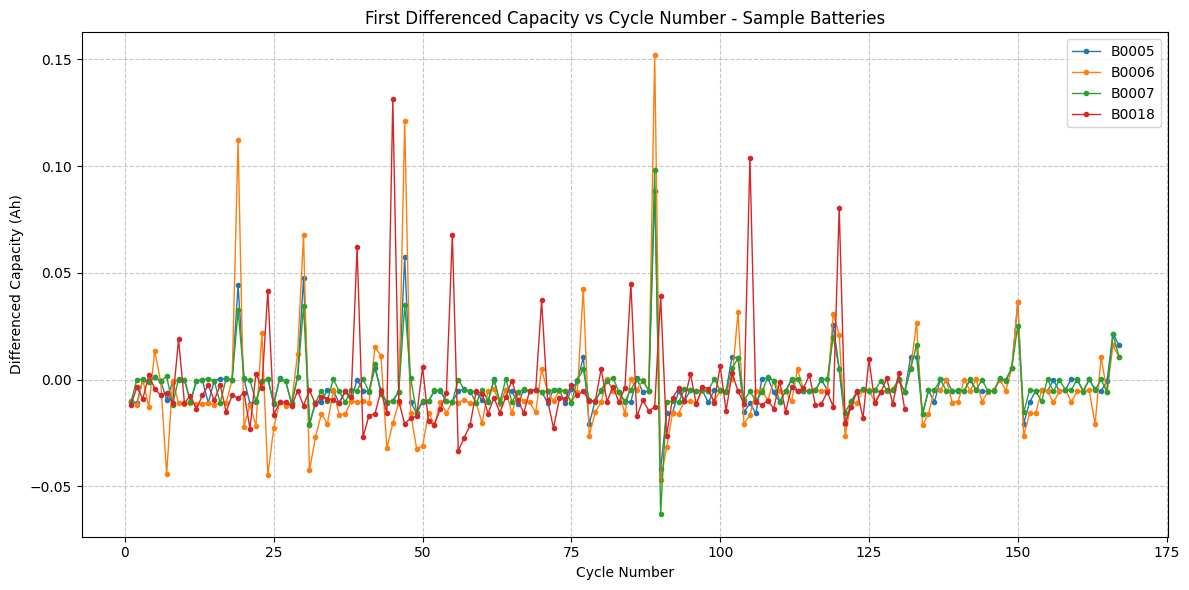

In [11]:
# Plot differenced Capacity vs Cycle Number for a few batteries
# After differencing, we expect to see random fluctuations around a constant mean

plt.figure(figsize=(12,6))

for b in sample_batteries:
    temp = discharge_df[discharge_df['battery_id'] == b]
    plt.plot(temp['cycle_number'], temp['capacity_diff'], marker='o', linestyle='-', markersize=3, linewidth=1, label=b)

plt.xlabel('Cycle Number')
plt.ylabel('Differenced Capacity (Ah)')
plt.title('First Differenced Capacity vs Cycle Number - Sample Batteries')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


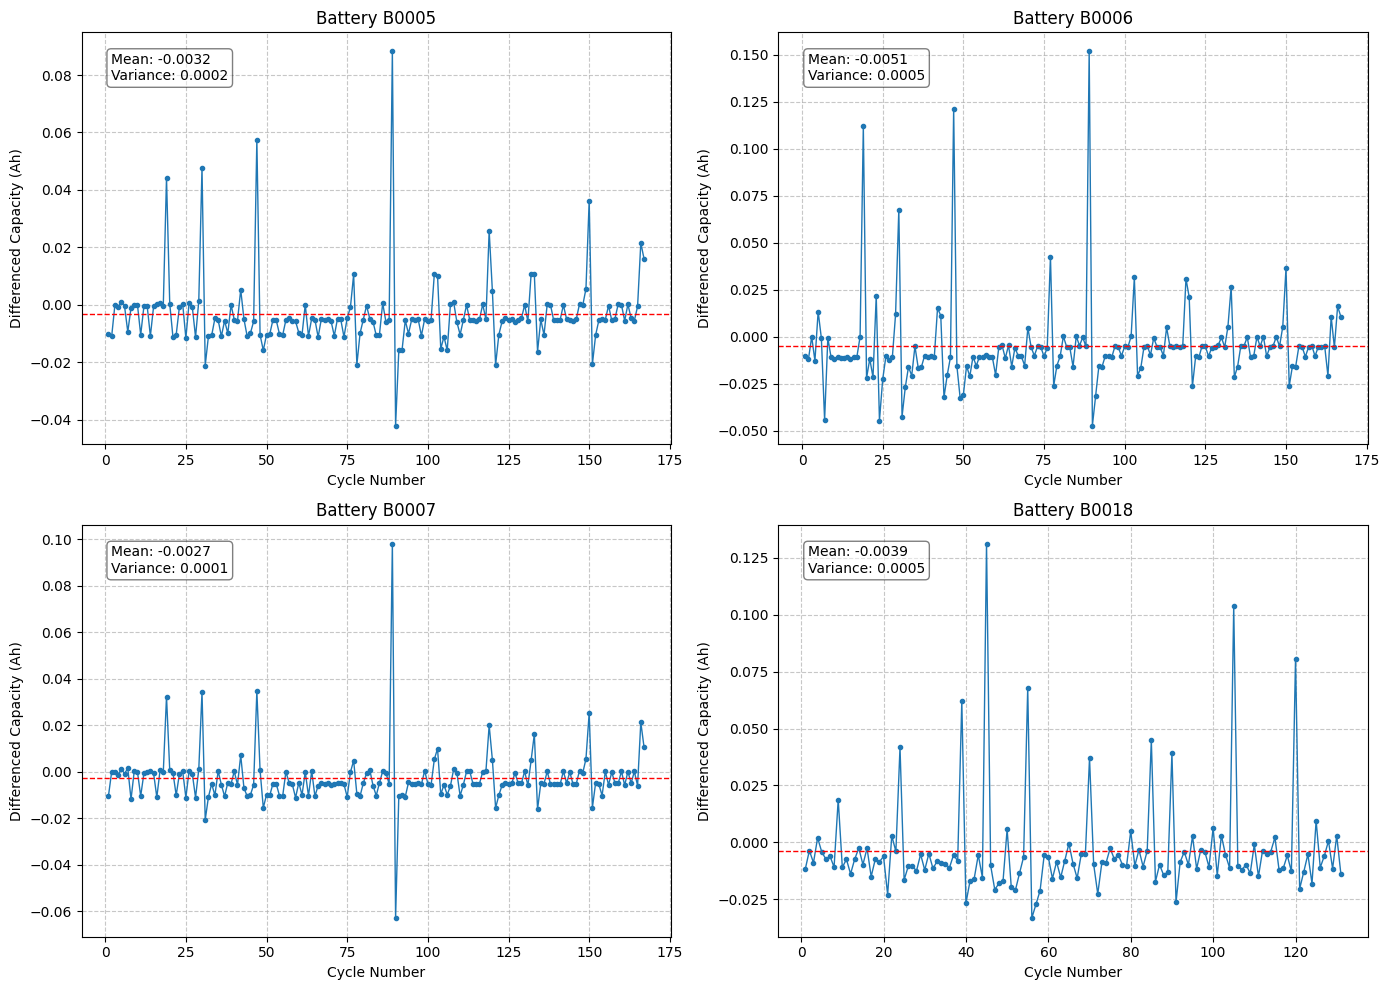

In [23]:
# Plot first differenced Capacity vs Cycle Number for sample batteries in a 2x2 grid
# Adding mean line and displaying mean/variance as text — key for confirming stationarity visually (Box-Jenkins)

import matplotlib.pyplot as plt

sample_batteries = discharge_df['battery_id'].unique()[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, b in enumerate(sample_batteries):
    temp = discharge_df[discharge_df['battery_id'] == b]
    
    mean_val = temp['capacity_diff'].mean()
    var_val = temp['capacity_diff'].var()
    
    axes[i].plot(temp['cycle_number'], temp['capacity_diff'], marker='o', linestyle='-', markersize=3, linewidth=1)
    axes[i].axhline(mean_val, color='red', linestyle='--', linewidth=1)
    
    axes[i].set_title(f'Battery {b}')
    axes[i].set_xlabel('Cycle Number')
    axes[i].set_ylabel('Differenced Capacity (Ah)')
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    textstr = f'Mean: {mean_val:.4f}\nVariance: {var_val:.4f}'
    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


In [14]:
# ADF Test again on differenced Capacity
# If the p-value drops below 0.05, the differenced series is now stationary and ready for ARIMA

for b in sample_batteries:
    temp = discharge_df[discharge_df['battery_id'] == b]
    print("\n")
    adf_test(temp['capacity_diff'], b)




Battery: B0005
ADF Statistic: -10.831429699417455
p-value: 1.7041928511248625e-19
Series is Stationary (p < 0.05)
--------------------------------------------------


Battery: B0006
ADF Statistic: -9.474156768993998
p-value: 4.031435741115568e-16
Series is Stationary (p < 0.05)
--------------------------------------------------


Battery: B0007
ADF Statistic: -11.025976471733493
p-value: 5.826943041646124e-20
Series is Stationary (p < 0.05)
--------------------------------------------------


Battery: B0018
ADF Statistic: -8.251993841564056
p-value: 5.360039287509761e-13
Series is Stationary (p < 0.05)
--------------------------------------------------


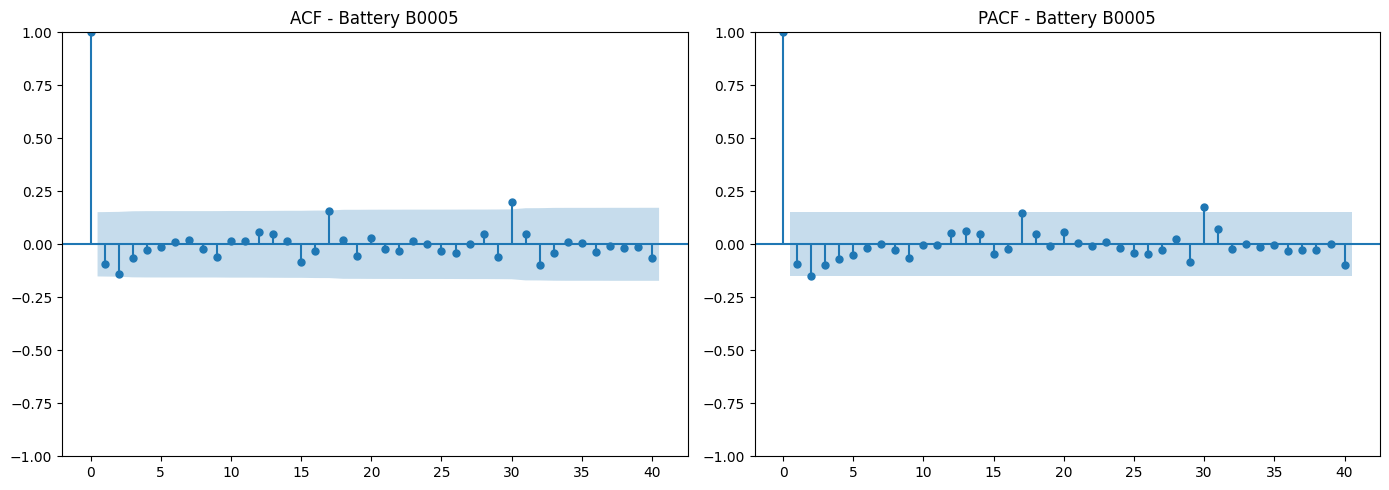

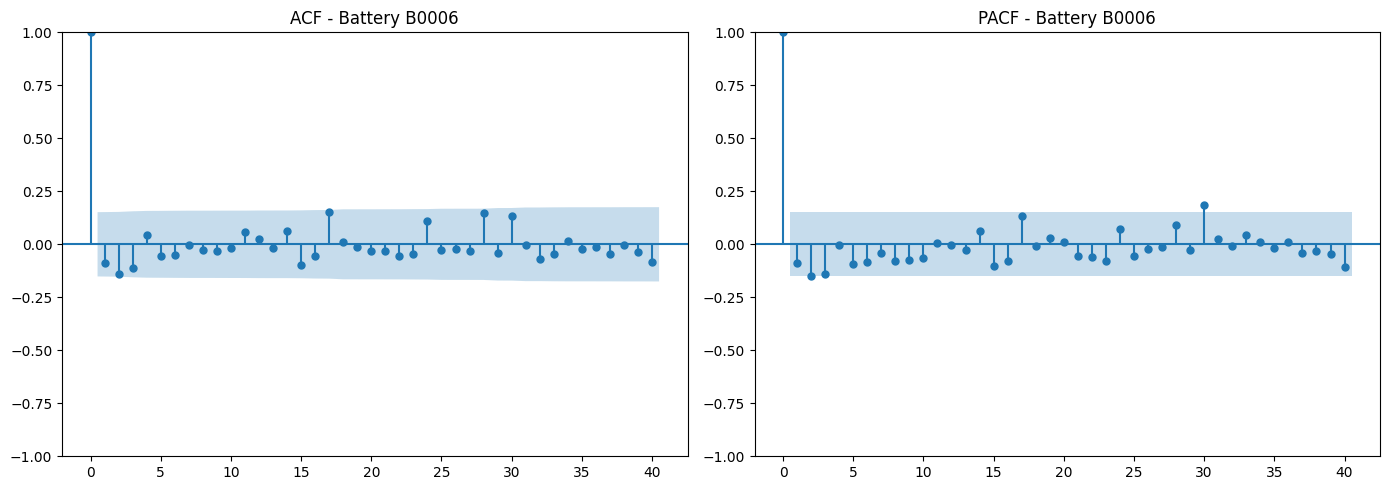

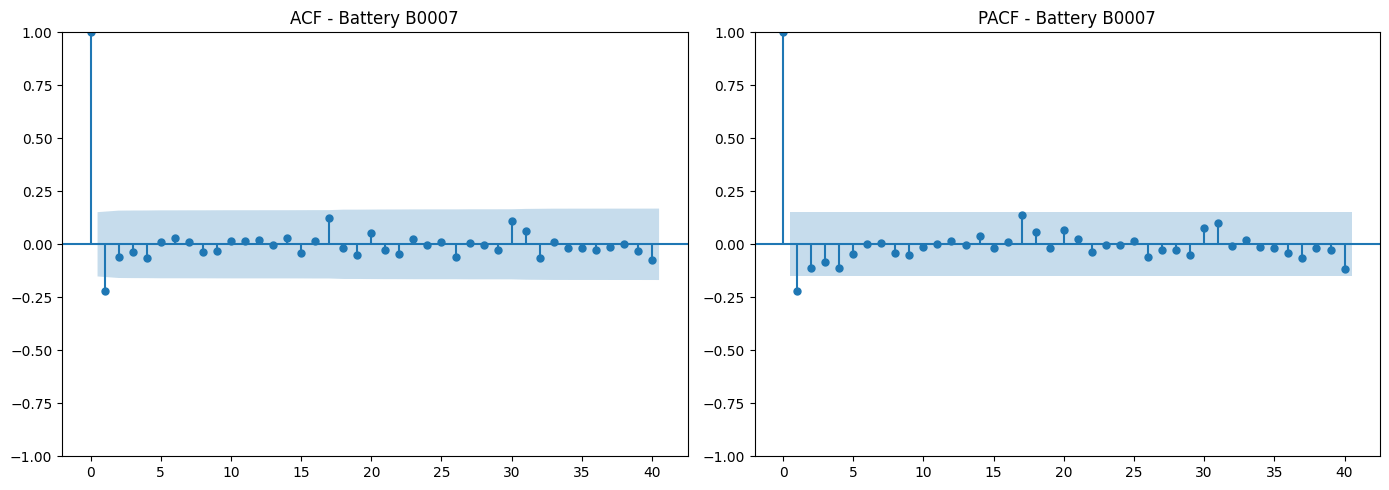

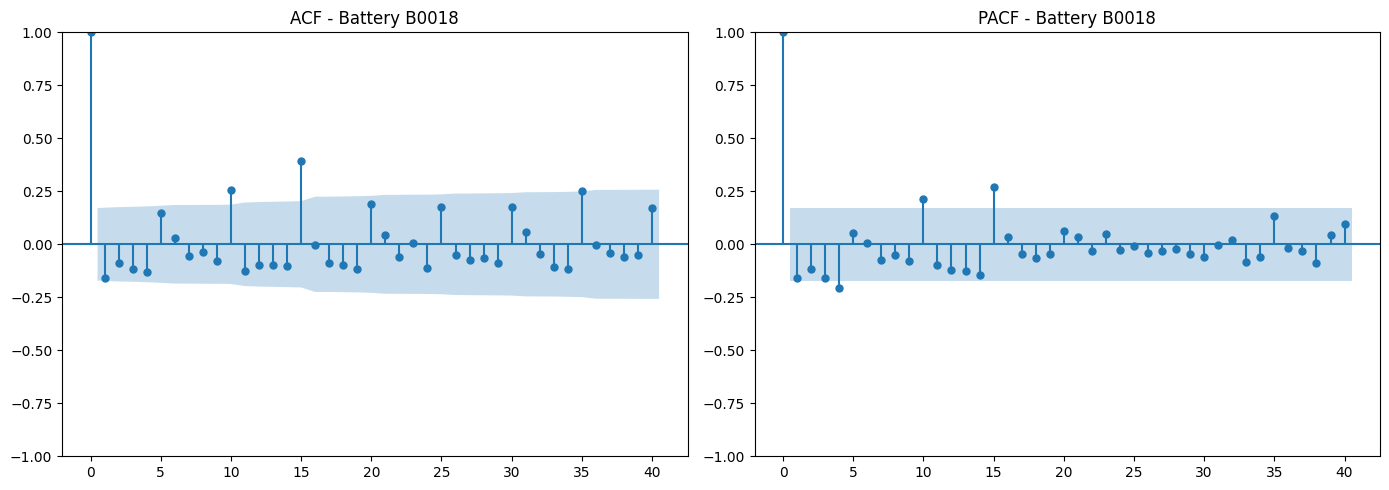

In [28]:
# Plot ACF and PACF for first differenced Capacity for each battery separately
# ACF guides MA(q) order, PACF guides AR(p) order — Box-Jenkins identification step

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sample_batteries = discharge_df['battery_id'].unique()[:4]

for b in sample_batteries:
    temp = discharge_df[discharge_df['battery_id'] == b]
    
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    plot_acf(temp['capacity_diff'].dropna(), lags=40, ax=axes[0])
    axes[0].set_title(f'ACF - Battery {b}')
    
    plot_pacf(temp['capacity_diff'].dropna(), lags=40, ax=axes[1])
    axes[1].set_title(f'PACF - Battery {b}')
    
    plt.tight_layout()
    plt.show()
